In [12]:
import pandas as pd # pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
# from sklearn import impute
from  scipy.stats import skew, kurtosis, shapiro
import datetime


plt.rc('axes', linewidth=2)
plt.rc('axes', labelsize= 16)
plt.rc('axes',titlesize = 18)
plt.rc('legend',fontsize=14)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
plt.rc('figure',figsize=(10,8))

def figure_layout(figsize=(10,8),titel="",xlabel="",ylabel="",fontsize_titel=18,fontsize_axis=16,fontsize_legend=14,fontsize_ticks=16):
    plt.figure(figsize=figsize)
    ax1 = plt.gca()
    plt.rc('legend',fontsize=fontsize_legend)
    plt.title(titel, fontsize=fontsize_titel, fontweight = 'bold')
    plt.grid(True)
    plt.xlabel(xlabel, fontsize=fontsize_axis)
    plt.ylabel(ylabel, fontsize=fontsize_axis)
    for tick in ax1.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize_ticks)
    #         tick.label1.set_fontweight('bold')
    for tick in ax1.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize_ticks)
    #     tick.label1.set_fontweight('bold')
    
    return ax1

### Load the data that consists of only full year observations.

In [13]:
fullYeardata = pd.read_csv("D:\Onedrive\Leuven\Final project\data\WrittenData\FullYeardata.csv",parse_dates=['date'], index_col='date') # Should change path
amount_measurements = fullYeardata.shape[0]
amount_meters = fullYeardata.shape[1]
print("The amount of measurements: {}.".format(amount_measurements))
print("The amount of meters: {}.".format(amount_meters))

The amount of measurements: 17520.
The amount of meters: 270.


In [43]:
fullYeardata.index[-1].dayofyear

365

### Investigating best way to subsitute the missing values

In [14]:
pct_NaN = fullYeardata.isnull().sum().sort_values().div(amount_measurements).mul(100)
print("The amount of missing data per smart meter ranges between {} % and {} %.".format(np.around(pct_NaN.min(),2),np.around(pct_NaN.max(),2)))

The amount of missing data per smart meter ranges between 1.1 % and 35.34 %.


In [15]:
data_MV = fullYeardata.copy(deep=True)
data_MV["month"] = data_MV.index.month_name()
data_MV = data_MV[data_MV["month"] == "March"]
data_MV.drop("month",axis='columns', inplace=True)
# visualization_NaN(["January","February","March","April","May","June","July","August","September","October","November","December"],"meter_3002")
print("Amount of meters with no missing days in the month March: {}.".format(len(data_MV.columns[data_MV.isnull().sum() == 0])))
col_no_missing = list(data_MV.columns[data_MV.isnull().sum() == 0])

Amount of meters with no missing days in the month March: 181.


In [16]:
reference = data_MV[col_no_missing].copy(deep=True)
test = reference.copy(deep = True)

In [17]:
# Select randomly 7 days that will be removed. 
removed_days = dict()
test["day"] = test.index.day
for col_ind in range(len(test.columns)):
    ID = test.columns[col_ind]
    rand_days = np.random.randint(2,31,size=7)
    # rand_days = np.array([1,2,3])
    removed_days[ID] = rand_days
    for i in rand_days:
        test.loc[test["day"] == i,ID] = np.nan
test.drop("day",axis=1,inplace = True)
print(test.isnull().sum())

meter_2979    288
meter_2981    288
meter_2983    336
meter_2986    336
meter_2988    336
             ... 
meter_3239    288
meter_3240    288
meter_3241    288
meter_3243    336
meter_3246    288
Length: 181, dtype: int64


In [23]:
# First look into a single meter
part_test = test.loc[:, 'meter_2981'] 

meter_2981    288
dtype: int64


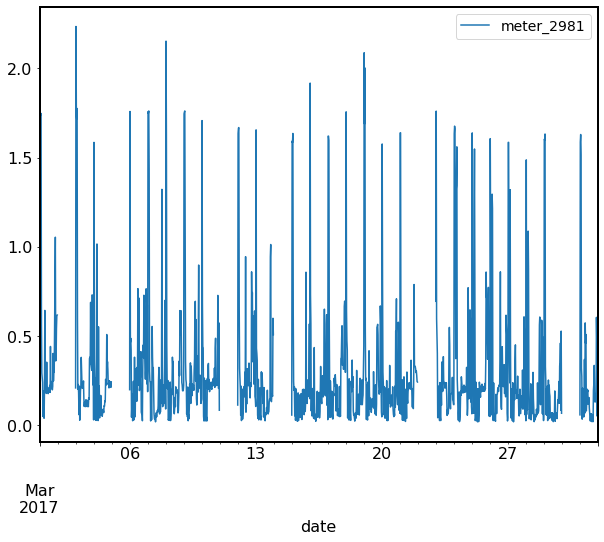

In [24]:
df = pd.DataFrame(index = part_test.index, data = part_test)
print(df.isnull().sum())
df.plot()

In [25]:
# Estimate the missing data based on previous and future observations
def estimated_mean_signal(test):
    # subsitude if necessary the first of january or the last day of december (general --> march in this test) then
    for col_ID in test.columns:
        missing_index = test.loc[pd.isna(test[col_ID]), :].index
        meanOfSerie = test[col_ID].mean()
        for date in missing_index:
            # if date.dayofyear == 1 or date.dayofyear == 365:
            if date.day == 1 or date.day == 31:
                estimation = meanOfSerie
                test.loc[date,col_ID] = estimation
    
    # subsitude the rest of the days
    for col_ID in test.columns:
        missing_index = test.loc[pd.isna(test[col_ID]), :].index
        for date in missing_index:
            n = 0
            next_measure_index = date + datetime.timedelta(days= 1)
            next_measure_value = test.loc[next_measure_index,col_ID]
            
            previous_measure_index = date + datetime.timedelta(days= -1)
            previous_measure_value = test.loc[previous_measure_index,col_ID]

            while np.isnan(next_measure_value) or np.isnan(previous_measure_value):
                n += 1
                            
                if np.isnan(next_measure_value) and np.isnan(previous_measure_value):

                    next_measure_index = date + datetime.timedelta(days= n + 1)
                    next_measure_value = test.loc[next_measure_index,col_ID]
                    previous_measure_index = date + datetime.timedelta(days= -1*(n + 1))
                    previous_measure_value = test.loc[next_measure_index,col_ID]
                
                elif np.isnan(next_measure_value):
                    next_measure_index = date + datetime.timedelta(days= n + 1)
                    next_measure_value = test.loc[next_measure_index,col_ID]

                elif np.isnan(previous_measure_value):
                    previous_measure_index = date + datetime.timedelta(days= -1*(n + 1))
                    previous_measure_value = test.loc[next_measure_index,col_ID]

                else:
                    raise Exception("Should have been excepted by one of the previous cases.")
                

            estimation = (next_measure_value + previous_measure_value)/2
            test.loc[date,col_ID] = estimation


In [26]:
df_copy = df.copy(deep=True)
estimated_mean_signal(df_copy)

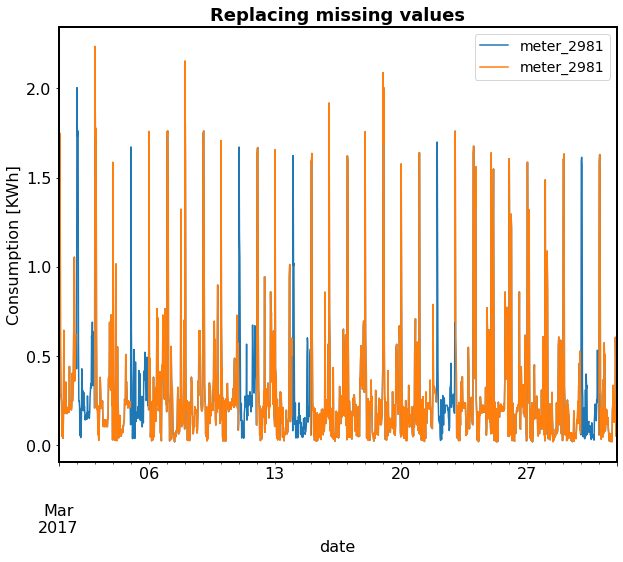

In [27]:
axis = figure_layout(figsize=(10,8),titel="Replacing missing values",xlabel="",ylabel="Consumption [KWh]",fontsize_titel=18,fontsize_axis=16,fontsize_legend=14,fontsize_ticks=16)
df_copy.plot(ax=axis,legend= "Replaced values")
df.plot(ax=axis,legend= "Missing values")
# It is possible that a prediction model can be considered to predict the missing values

Now use only the mean of the signal to subsitute the missing values

In [28]:
df_copy2 = df.copy(deep=True)
my_imputer = SimpleImputer()
data_with_imputed_values = my_imputer.fit_transform(df_copy2) # calculating the mean of each column and switch it with the missing values of the column
df_copy2 = pd.DataFrame(data = data_with_imputed_values,index=df_copy2.index,columns=df_copy2.keys())
pct_NaN = df_copy2.isnull().sum().sort_values().div(1).mul(100)
print("The amount of missing data per smart meter ranges between {}% and {}%.".format(pct_NaN.min(),pct_NaN.max()))

The amount of missing data per smart meter ranges between 0.0% and 0.0%.


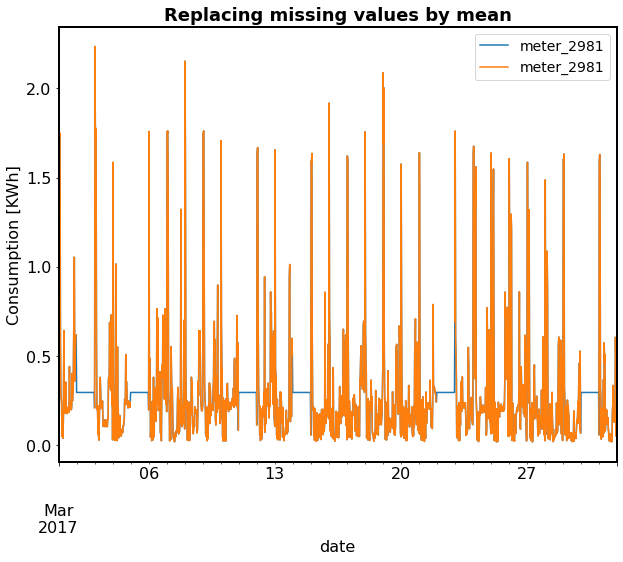

In [29]:

axis = figure_layout(figsize=(10,8),titel="Replacing missing values by mean",xlabel="",ylabel="Consumption [KWh]",fontsize_titel=18,fontsize_axis=16,fontsize_legend=14,fontsize_ticks=16)
df_copy2.plot(ax=axis,legend= "Replaced values")
df.plot(ax=axis,legend= "Missing values")

In [30]:
part_ref = reference.loc[:, 'meter_2981']
print("The amount of NaN values in the reference: {}".format(part_ref.isnull().sum())) #The reference values
MSE = df_copy.subtract(part_ref,axis=0).pow(2).sum().div(amount_measurements)[0]
print(MSE)
MSE_mean = df_copy2.subtract(part_ref,axis=0).pow(2).sum().div(amount_measurements)[0]
print(MSE_mean)

The amount of NaN values in the reference: 0
0.001472721475456621
0.0021381620913698634


['MSE Average Neighbours', 'MSE Mean']


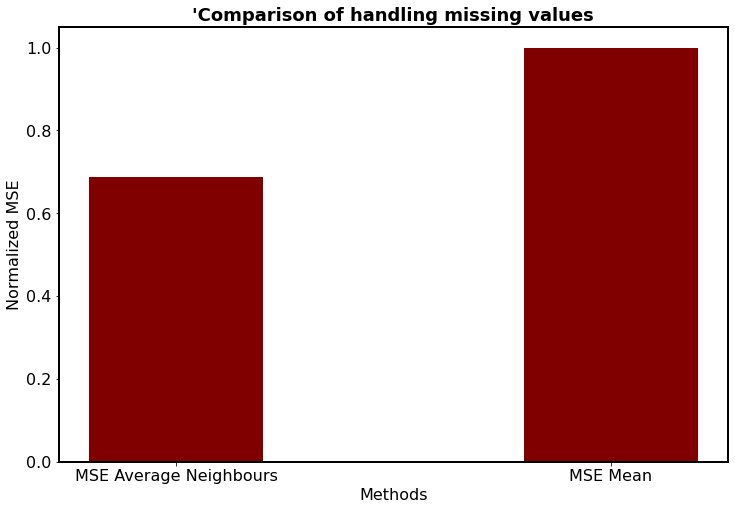

In [31]:
data = {'MSE Average Neighbours': MSE/MSE_mean, 'MSE Mean': MSE_mean/MSE_mean} # Normalized
MSEs = list(data.keys()) 
values = list(data.values()) 
   
axis = figure_layout(figsize=(12,8),titel="'Comparison of handling missing values",xlabel="Methods",ylabel="Normalized MSE",fontsize_titel=18,fontsize_axis=16,fontsize_legend=14,fontsize_ticks=16)
axis.grid(False)
print(MSEs)  
# creating the bar plot 
axis.bar(MSEs, values, color ='maroon',width = 0.4) 
  
plt.show() 

### Comparing the two methods by calculating the MSE based on all the meters in the test dataframe. (181 meters)

In [32]:
test_AN = test.copy(deep=True)

In [33]:
# This can take a while (+- 3 min)
print(test_AN.isnull().sum())
estimated_mean_signal(test_AN)

meter_2979    288
meter_2981    288
meter_2983    336
meter_2986    336
meter_2988    336
             ... 
meter_3239    288
meter_3240    288
meter_3241    288
meter_3243    336
meter_3246    288
Length: 181, dtype: int64


In [34]:
print(test_AN.isnull().sum())

meter_2979    0
meter_2981    0
meter_2983    0
meter_2986    0
meter_2988    0
             ..
meter_3239    0
meter_3240    0
meter_3241    0
meter_3243    0
meter_3246    0
Length: 181, dtype: int64


In [35]:
MSE_complete = test_AN.subtract(reference,axis=0).pow(2).sum(axis=0).sum(axis=0)/amount_measurements
print(MSE_complete)

0.19791741197470747


In [36]:
print("The amount of NaN values in the test: {}".format(test.isnull().sum().sum()))

The amount of NaN values in the test: 54336


Now use only the mean of the signal to subsitute the missing values

In [37]:
my_imputer = SimpleImputer()
data_with_imputed_values = my_imputer.fit_transform(test) # calculating the mean of each column and switch it with the missing values of the column
test_M = pd.DataFrame(data = data_with_imputed_values,index=test.index,columns=test.keys())

In [38]:
pct_NaN = test_M.isnull().sum().sort_values().div(1).mul(100)
print("The amount of missing data per smart meter ranges between {}% and {}%.".format(pct_NaN.min(),pct_NaN.max()))

The amount of missing data per smart meter ranges between 0.0% and 0.0%.


In [39]:
MSE_M_complete = test_M.subtract(reference,axis=0).pow(2).sum(axis=0).sum(axis=0)/amount_measurements # instead of dividing over all the measurements it is maybe better to only divide over the amount of estimated valeus. 
# However this doesn't matter when the error is normalized for comparison. 
print(MSE_M_complete)

0.25728725437755345


['MSE Average Neighbours', 'MSE Mean']


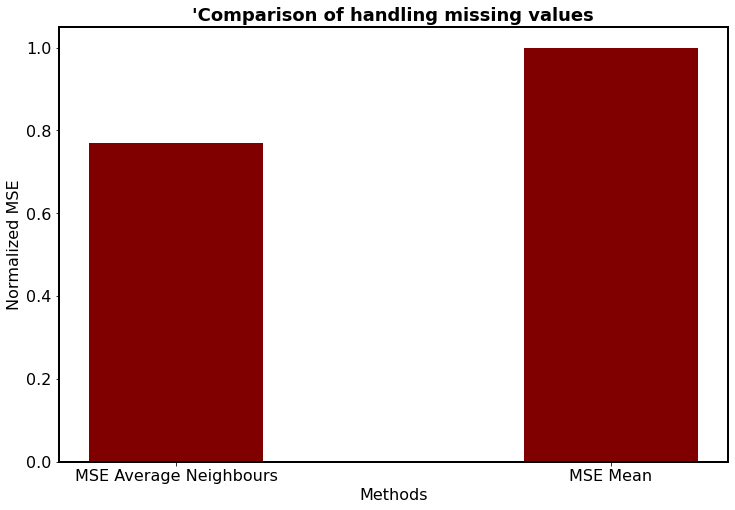

In [40]:
data = {'MSE Average Neighbours': MSE_complete/MSE_M_complete, 'MSE Mean': MSE_M_complete/MSE_M_complete} # Normalized
MSEs = list(data.keys()) 
values = list(data.values()) 
   
axis = figure_layout(figsize=(12,8),titel="Comparison of handling missing values",xlabel="Methods",ylabel="Normalized MSE",fontsize_titel=18,fontsize_axis=16,fontsize_legend=14,fontsize_ticks=16)
axis.grid(False)
print(MSEs)  
# creating the bar plot 
axis.bar(MSEs, values, color ='maroon',width = 0.4) 
  
plt.show() 